# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [2]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator

DATA_DIR = 'data'

## Task 0: Research Question

**Research question:**
*Can we identify different student profiles based on their behaviors and understand how these profiles relate to academic performance?*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### A) Student Activity (Inputs):

##### 1) Student Activity Cleaning:

**Approach:**

We will begin by loading the `activity` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)  
- Remove entries with missing `activity_completed` values or inconsistent timestamps (e.g., when completion occurs before the activity starts)  
- Remove entries where the activity duration exceeds 24 hours, as these likely indicate inactivity (e.g., students leaving the activity open)

In [3]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

In addition to removing entries where the activity duration exceeds 24 hours, we will also eliminate remaining outliers using the IQR method, as it is still unlikely that a student would spend several hours on a single activity. The IQR method provides a statistically grounded threshold for identifying such outliers, removing the need to define a manual cutoff.

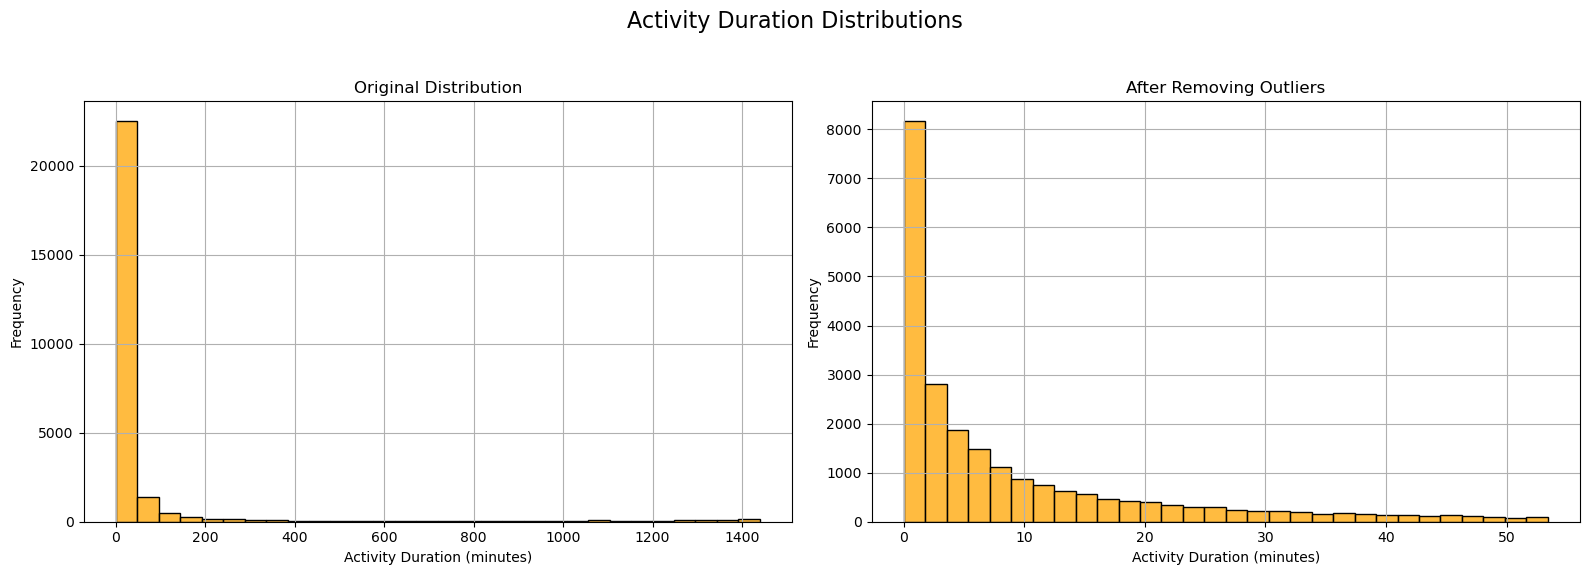

In [4]:
# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions", fontsize=16)

# Before filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[0])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Activity Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]
activity_sizes['After removing remaining outliers'] = len(activity)

# After filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[1])
axes[1].set_title('After Removing Outliers')
axes[1].set_xlabel('Activity Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")


Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
- After removing remaining outliers: 22754 entries (31.21%)


**Observation:**

We observe that before applying the IQR method to filter out remaining outliers, the distribution of activity duration is right-skewed, with numerous extreme values reaching up to 1,400 mins (≈ 23 hours).

After removing these outliers, the distribution remains right-skewed (likely an exponential distribution), with durations ranging from 0 minutes to 1 hour.

Empirically, we found that the IQR method performs more effectively when applied after first removing entries with durations exceeding 24 hours, rather than relying on it alone.

After applying all filters, we are left with about 31% of the original dataset (22,754 entries). The most significant reduction occurs when removing entries with missing or inconsistent completion times, which alone reduces the dataset from 100% to 53%.  

One possible solution to retain more data would be to predict the missing completion times. However, this could compromise the reliability of the analysis by introducing less representative user behavior. Therefore, we chose to leave this as a potential direction for future work, if necessary.

##### 2) Student Feature Creation:

We will now compute a set of features for each student to enable clustering and identify different profiles. The final dataframe should contain one row per student, with columns summarizing their activity.

In [ ]:
import pandas as pd
import numpy as np

# Copy for modification
activity_periods = activity.copy(deep=True)

# Convert activity_started to datetime just in case
activity_periods['activity_started'] = pd.to_datetime(activity_periods['activity_started'])

# 1. Compute min and max activity time
min_time = activity_periods['activity_started'].min()
max_time = activity_periods['activity_started'].max()

# 2. Compute bucket edges for 3 periods
period_edges = pd.date_range(start=min_time, end=max_time, periods=4)  # 3 periods -> 4 edges

# 3. Assign period (1, 2, or 3) to each row
def assign_period(ts):
    for i in range(3):
        if period_edges[i] <= ts < period_edges[i+1]:
            return i + 1
    return 3  # Include edge case where ts == max_time

activity_periods['period'] = activity_periods['activity_started'].apply(assign_period)

# 4. Extract unique (user_id, period) combinations
user_periods = activity_periods[['user_id', 'period']].drop_duplicates()

# 5. Merge user_activity with user_periods to duplicate user info across periods
user_activity_with_periods = user_periods.merge(user_activity, on='user_id', how='left')

# 6. Reorder columns
user_activity_with_periods = user_activity_with_periods[
    ['user_id', 'median_gap_days', 'active_days_count', 'activities_count',
     'activity_types_count', 'median_activity_duration_minutes', 'period']
].sort_values(['user_id', 'period'])

# Show result
print("User Activity with Periods:")
display(user_activity_with_periods.head())
print("Shape:", user_activity_with_periods.shape)


Activity per User:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_5363/2776266635.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_activity['median_activity_duration'] = activity.groupby('user_id').apply(


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Shape: (843, 6)


In [75]:
import pandas as pd

def create_user_activity_by_period(activity_df, periods):
    """
    Creates user activity dataframes separated by time periods.
    
    Parameters:
    -----------
    activity_df : pandas DataFrame
        The original activity dataframe
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods
    
    Returns:
    --------
    dict
        Dictionary of user_activity dataframes for each period
    """
    user_activity_periods = {}
    
    for start_date, end_date, period_name in periods:
        print(f"\n--- Processing {period_name} ({start_date} to {end_date}) ---")
        
        # Filter activities for current period
        period_activity = activity_df[
            (activity_df['activity_started'] >= pd.Timestamp(start_date)) & 
            (activity_df['activity_started'] < pd.Timestamp(end_date))
        ].copy(deep=True)
        
        print(f"Activities in {period_name}: {len(period_activity)}")
        
        if len(period_activity) == 0:
            print(f"No activities in {period_name}, skipping...")
            continue
            
        # Create daily activity dataframe for this period
        user_daily_activity = period_activity.copy(deep=True)

        # Create new column for activity started day
        user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

        # Drop duplicates in user_id, active_day
        user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

        # Compute gaps between active days for each user
        user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
        user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
        user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

        # Keep only relevant columns
        columns = ['user_id', 'active_day', 'gap_days']
        user_daily_activity = user_daily_activity[columns]

        # Create the aggregated user_activity dataframe for this period
        # Compute the median of gap_days per user
        user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
        user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

        # Add the number of active days of that user (count)
        user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

        # Add the median activity duration of that user (only when activity_completed is not missing)
        duration_median = period_activity.groupby('user_id').apply(
            lambda x: (x['activity_completed'] - x['activity_started']).median()
        )
        user_activity['median_activity_duration'] = duration_median.reset_index(drop=True)

        # Add the number of activities of that user (count)
        user_activity['activities_count'] = period_activity.groupby('user_id')['activity_id'].count().values
        
        # Add the number of unique activity types of that user
        user_activity['activity_types_count'] = period_activity.groupby('user_id')['activity_type'].nunique().values

        # Convert timedelta to minutes
        user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60

        # Drop the original timedelta column
        user_activity.drop(columns=['median_activity_duration'], inplace=True)
        
        # Add period information
        user_activity['period'] = period_name
        
        # Store in dictionary
        user_activity_periods[period_name] = user_activity
        
        print(f"\nActivity per User for {period_name}:")
        display(user_activity.head())
        print(f"Shape: {user_activity.shape}")
        
    return user_activity_periods

# Define the periods (start_date, end_date, period_name)
periods = [
    ('2023-01-01', '2024-09-01', '2023'),
    ('2024-09-01', '2025-01-01', '2024'),
    ('2025-01-01', '2026-01-01', '2025')
]

# Create user activity dataframes for each period
user_activity_periods = create_user_activity_by_period(activity, periods)

# Access individual period dataframes
user_activity_2023 = user_activity_periods['2023']
user_activity_2024 = user_activity_periods['2024']
user_activity_2025 = user_activity_periods['2025']

# You can also combine them into a single dataframe with period information
all_periods_user_activity = pd.concat(user_activity_periods.values(), ignore_index=True)
print("\nAll periods combined:")
display(all_periods_user_activity.head())
print(f"Shape: {all_periods_user_activity.shape}")

# Check how many users appear in multiple periods
user_period_counts = all_periods_user_activity.groupby('user_id')['period'].nunique()
users_in_multiple_periods = user_period_counts[user_period_counts > 1].count()
print(f"\nUsers active in multiple periods: {users_in_multiple_periods}")


--- Processing 2023 (2023-01-01 to 2024-09-01) ---
Activities in 2023: 2870



Activity per User for 2023:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_5363/1866392571.py:63: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,1328,NaN,1,1,1,1.383333,2023
1,1507,NaN,1,1,1,0.416667,2023
2,1607,NaN,1,1,1,0.083333,2023
3,1608,NaN,1,1,1,0.116667,2023
4,1611,6.0,2,2,1,42.791667,2023


Shape: (231, 7)

--- Processing 2024 (2024-09-01 to 2025-01-01) ---
Activities in 2024: 14448

Activity per User for 2024:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_5363/1866392571.py:63: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,1,5.5,5,12,2,3.491667,2024
1,4,7.0,6,30,1,2.008333,2024
2,6,8.0,4,14,2,4.775000,2024
3,7,4.0,14,26,2,12.683333,2024
4,9,10.0,7,19,2,8.550000,2024


Shape: (676, 7)

--- Processing 2025 (2025-01-01 to 2026-01-01) ---
Activities in 2025: 5436

Activity per User for 2025:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_5363/1866392571.py:63: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,1,4.0,6,7,2,4.716667,2025
1,4,NaN,1,1,1,10.400000,2025
2,6,4.0,5,16,2,13.333333,2025
3,7,3.0,2,4,1,21.258333,2025
4,9,NaN,1,7,2,1.550000,2025


Shape: (414, 7)

All periods combined:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,1328,NaN,1,1,1,1.383333,2023
1,1507,NaN,1,1,1,0.416667,2023
2,1607,NaN,1,1,1,0.083333,2023
3,1608,NaN,1,1,1,0.116667,2023
4,1611,6.0,2,2,1,42.791667,2023


Shape: (1321, 7)

Users active in multiple periods: 416


In [76]:
# Number of unique users in each period
unique_users_2023 = user_activity_2023['user_id'].nunique()
unique_users_2024 = user_activity_2024['user_id'].nunique()
unique_users_2025 = user_activity_2025['user_id'].nunique()
print(f"\nUnique users in 2023: {unique_users_2023}")
print(f"Unique users in 2024: {unique_users_2024}")
print(f"Unique users in 2025: {unique_users_2025}")


Unique users in 2023: 231
Unique users in 2024: 676
Unique users in 2025: 414


We now have our `user_activity` (input) dataframe, where each row corresponds to a student and includes their activity features. Their descriptions and distributions will be discussed later in Task 1.C.

### B) Student Scores (Target):

**Approach:**

We will begin by loading the `all_scores` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)
- Aggregate the scores for each student by computing the median of their scores
- Remove outliers

In [77]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')


--- Processing Scores for 2023 (2023-01-01 to 2024-09-01) ---
Scores in 2023: 282
Users with at least 2 scores in 2023: 47


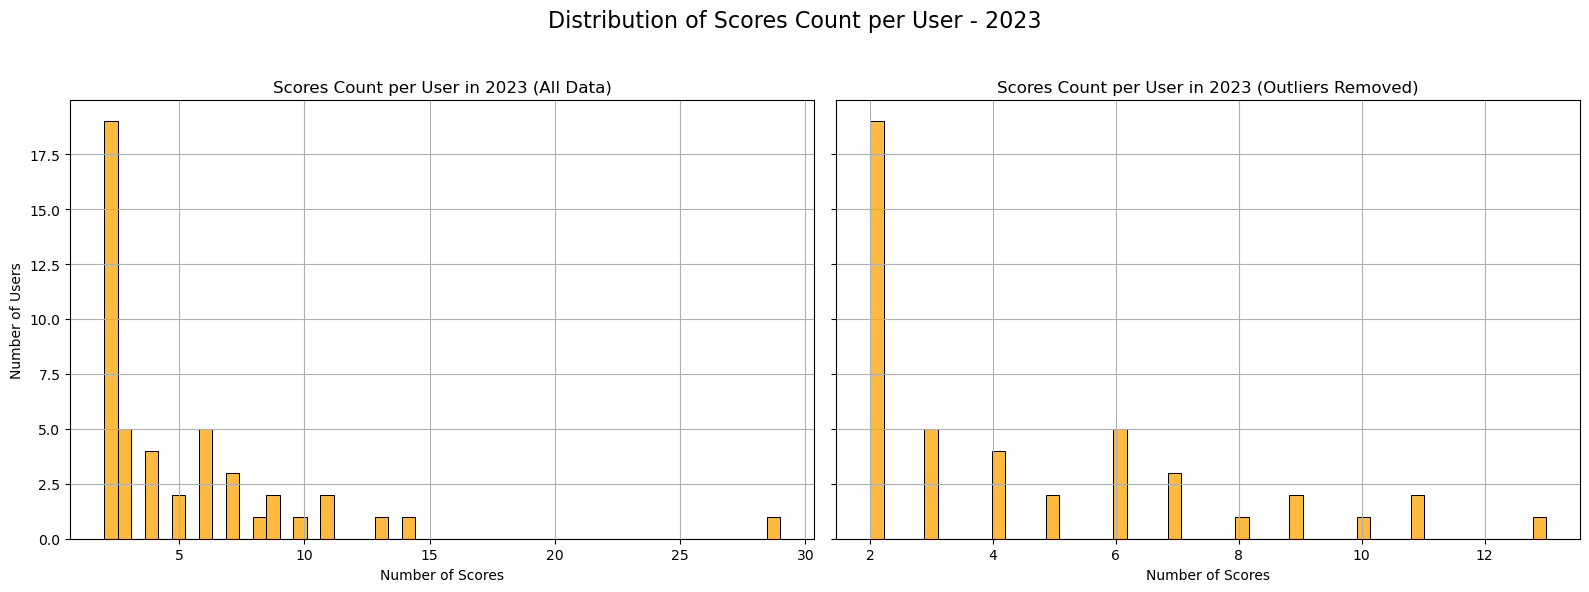

Number of users before outlier removal: 47
Number of users after outlier removal: 45 (95.74%)


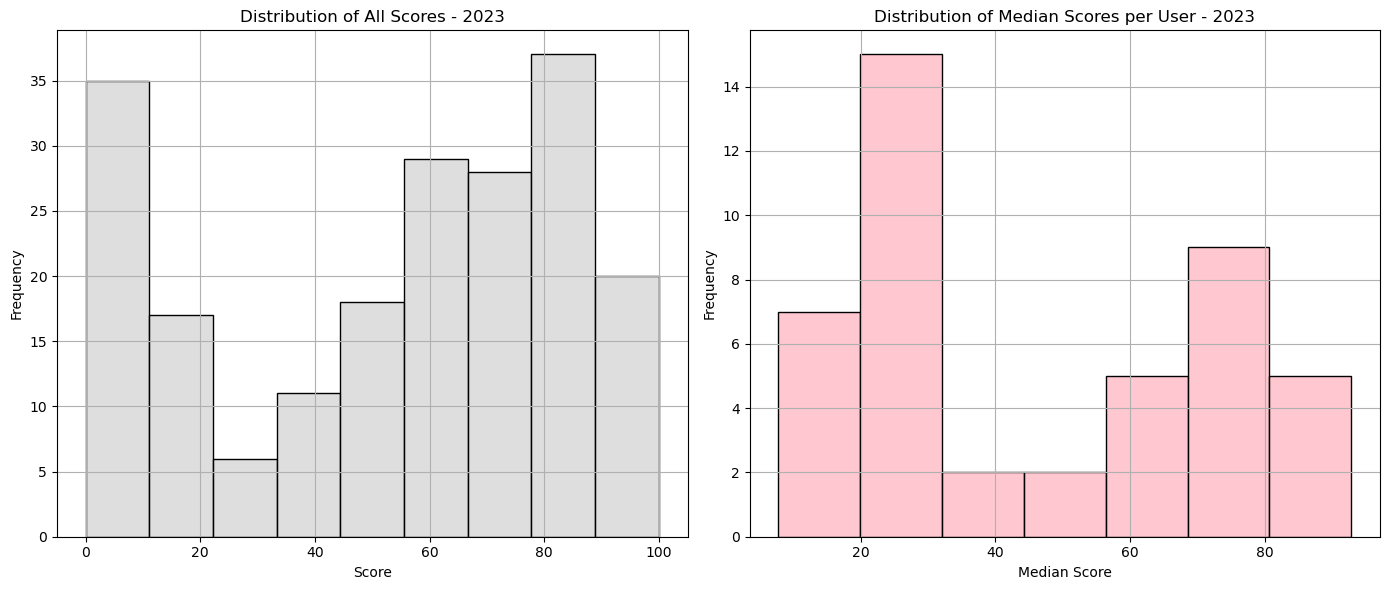

Number of users in user_activity for 2023: 231
Number of users in students_median_score for 2023: 45
Number of users after merging for 2023: 26

Sample of merged data for 2023:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,2235,2.0,8,23,2,8.550000,2023,54.285,4
1,2533,5.0,9,34,3,1.258333,2023,12.145,6
2,2540,NaN,1,18,3,0.575000,2023,15.000,4
3,2602,4.5,7,71,4,2.750000,2023,60.000,3
4,2628,2.0,12,38,3,11.591667,2023,62.500,7



--- Processing Scores for 2024 (2024-09-01 to 2025-01-01) ---
Scores in 2024: 5025
Users with at least 2 scores in 2024: 432


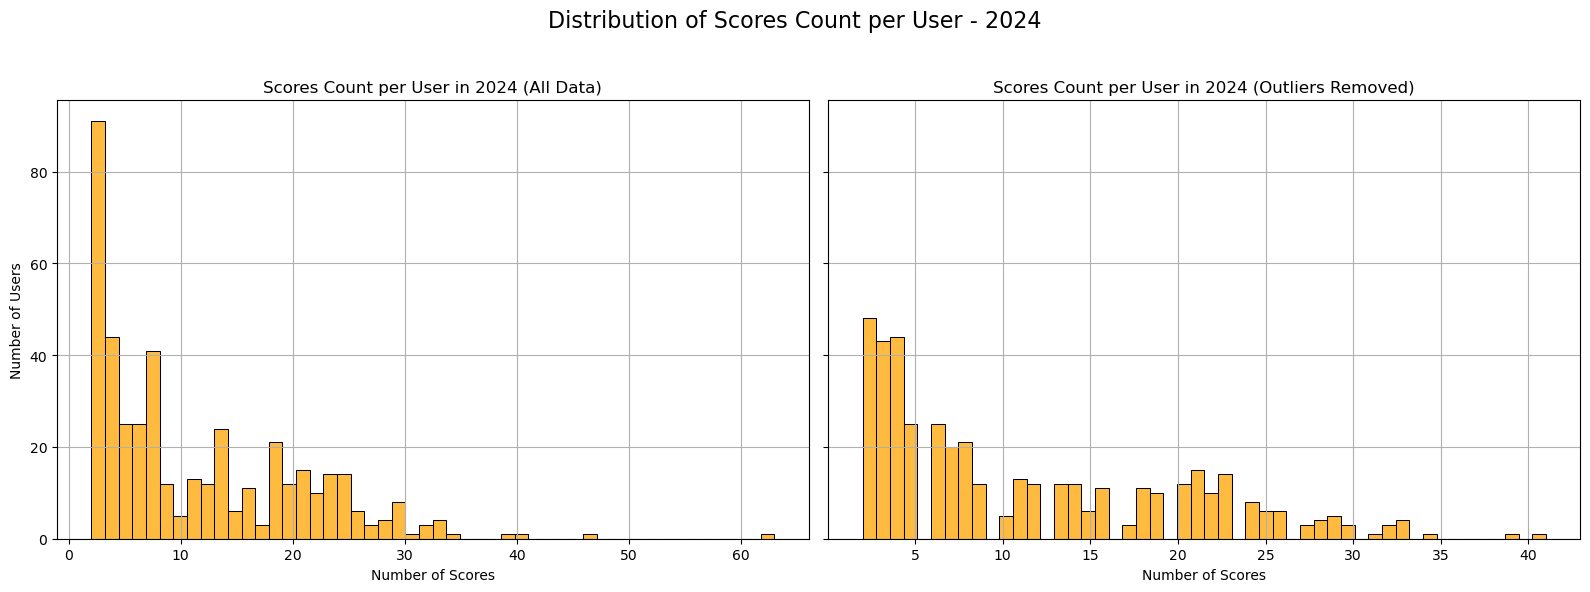

Number of users before outlier removal: 432
Number of users after outlier removal: 430 (99.54%)


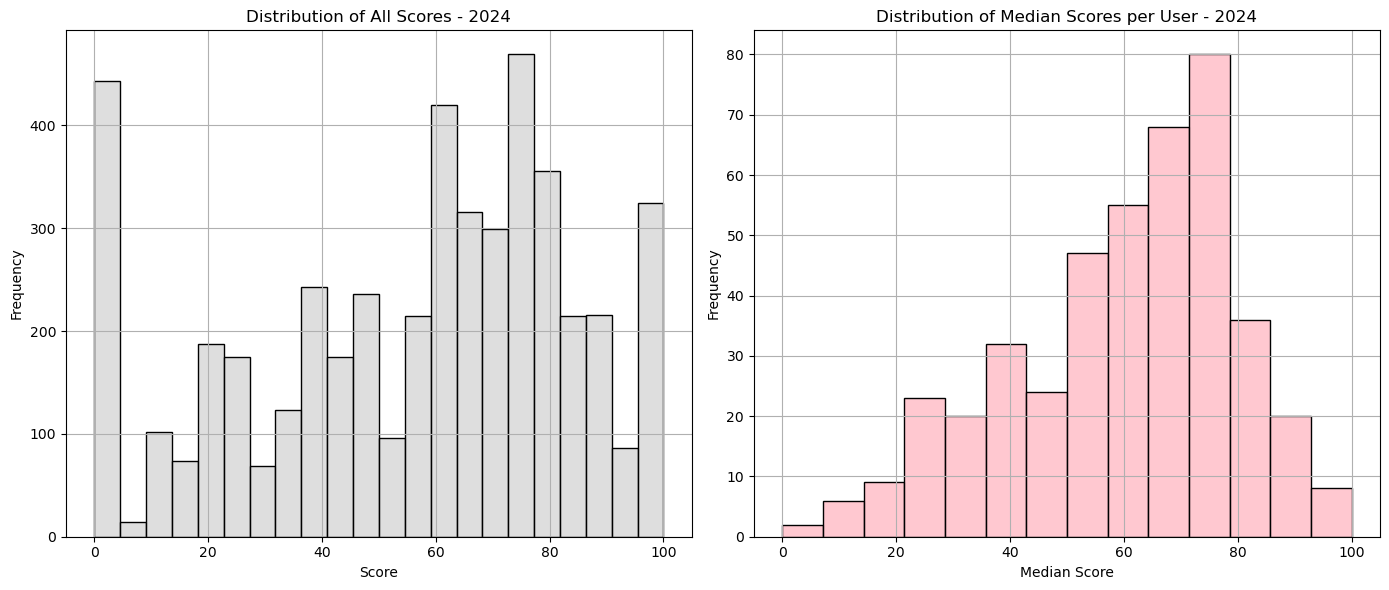

Number of users in user_activity for 2024: 676
Number of users in students_median_score for 2024: 430
Number of users after merging for 2024: 395

Sample of merged data for 2024:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,1,5.5,5,12,2,3.491667,2024,59.147059,2
1,4,7.0,6,30,1,2.008333,2024,71.000000,3
2,6,8.0,4,14,2,4.775000,2024,67.000000,9
3,7,4.0,14,26,2,12.683333,2024,74.000000,5
4,9,10.0,7,19,2,8.550000,2024,50.000000,3



--- Processing Scores for 2025 (2025-01-01 to 2026-01-01) ---
Scores in 2025: 1125
Users with at least 2 scores in 2025: 205


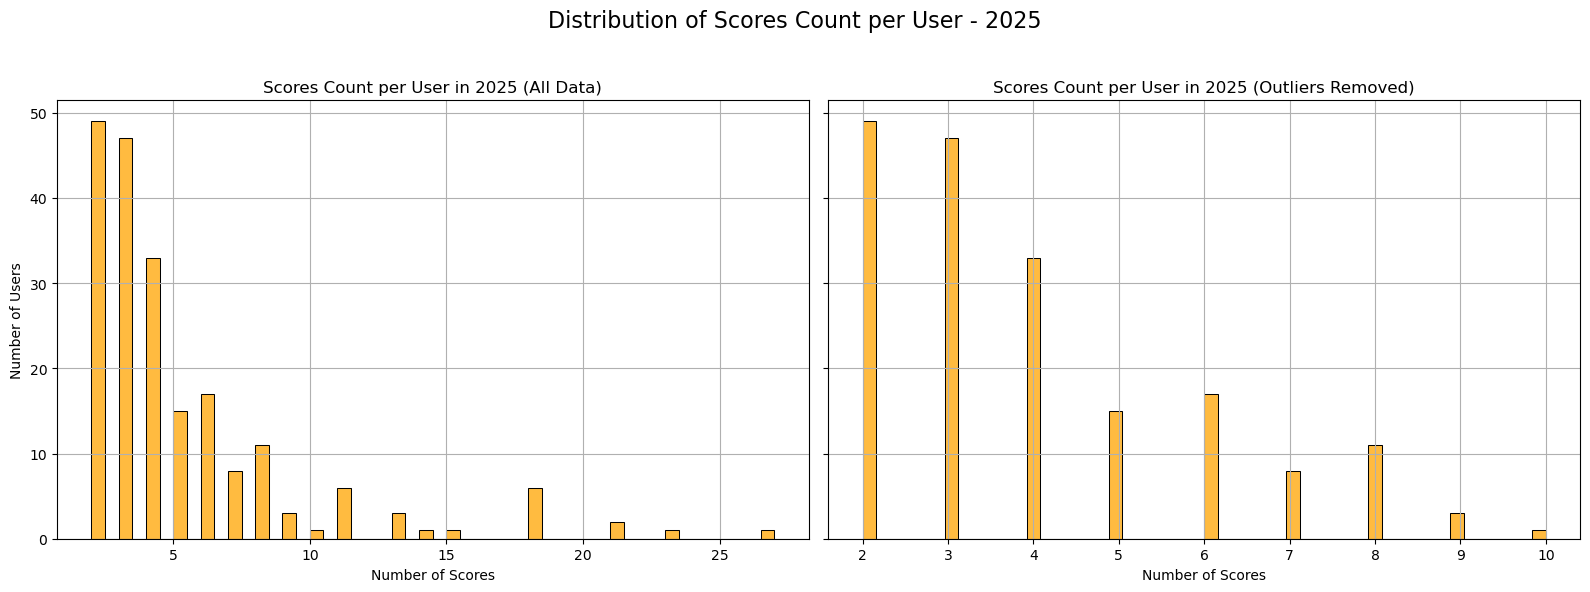

Number of users before outlier removal: 205
Number of users after outlier removal: 184 (89.76%)


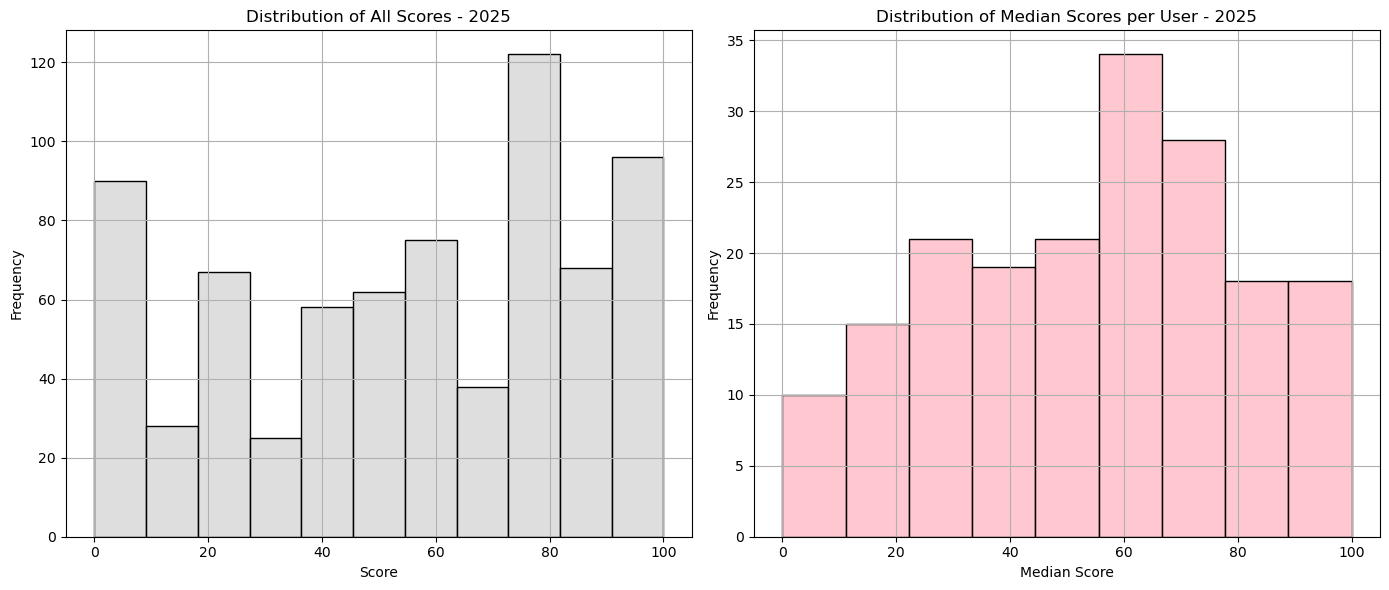

Number of users in user_activity for 2025: 414
Number of users in students_median_score for 2025: 184
Number of users after merging for 2025: 175

Sample of merged data for 2025:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,6,4.0,5,16,2,13.333333,2025,50.000,5
1,9,NaN,1,7,2,1.550000,2025,40.000,2
2,11,2.0,4,13,1,6.083333,2025,16.250,2
3,17,28.5,3,4,1,14.550000,2025,70.835,4
4,48,2.0,2,8,2,8.333333,2025,65.000,2



All periods combined:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,2235,2.0,8,23,2,8.550000,2023,54.285,4
1,2533,5.0,9,34,3,1.258333,2023,12.145,6
2,2540,NaN,1,18,3,0.575000,2023,15.000,4
3,2602,4.5,7,71,4,2.750000,2023,60.000,3
4,2628,2.0,12,38,3,11.591667,2023,62.500,7


Shape: (596, 9)

Analyzing user presence across periods:
Period 2023: 26 unique users
Period 2024: 395 unique users
Period 2025: 175 unique users
Users appearing in exactly 1 periods: 313
Users appearing in exactly 2 periods: 137
Users appearing in exactly 3 periods: 3


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods):
    """
    Computes median scores per user for each period and merges with corresponding user_activity
    
    Parameters:
    -----------
    all_scores : pandas DataFrame
        DataFrame containing all user scores
    user_activity_periods : dict
        Dictionary of user_activity dataframes for each period
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods
    
    Returns:
    --------
    dict
        Dictionary of merged student dataframes for each period
    """
    students_by_period = {}
    
    for start_date, end_date, period_name in periods:
        print(f"\n--- Processing Scores for {period_name} ({start_date} to {end_date}) ---")
        
        # Filter scores for current period
        period_scores = all_scores[
            (all_scores['time'] >= pd.Timestamp(start_date)) & 
            (all_scores['time'] < pd.Timestamp(end_date))
        ].copy(deep=True)
        
        print(f"Scores in {period_name}: {len(period_scores)}")
        
        if len(period_scores) == 0:
            print(f"No scores in {period_name}, skipping...")
            continue
            
        # Get the user_activity for this period
        user_activity = user_activity_periods.get(period_name)
        
        if user_activity is None or len(user_activity) == 0:
            print(f"No user activity data for {period_name}, skipping...")
            continue
        
        # Compute median and count of scores per user for this period
        students_median_score = period_scores.groupby('user_id')['percentage'].median().reset_index()
        students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
        students_median_score['scores_count'] = period_scores.groupby('user_id')['percentage'].count().values

        # Remove users with less than 2 scores (as in original code)
        students_median_score_filtered = students_median_score[students_median_score['scores_count'] > 1]
        
        print(f"Users with at least 2 scores in {period_name}: {len(students_median_score_filtered)}")
        
        # Plot distribution of scores count per user before outlier removal
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        sns.histplot(students_median_score_filtered['scores_count'], bins=50, ax=axes[0], color='orange')
        axes[0].set_title(f'Scores Count per User in {period_name} (All Data)')
        axes[0].set_xlabel('Number of Scores')
        axes[0].set_ylabel('Number of Users')
        axes[0].grid()

        # IQR Outlier Removal
        Q1 = students_median_score_filtered['scores_count'].quantile(0.25)
        Q3 = students_median_score_filtered['scores_count'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter in-place
        length_before = len(students_median_score_filtered)
        students_median_score_filtered = students_median_score_filtered[
            (students_median_score_filtered['scores_count'] >= lower_bound) & 
            (students_median_score_filtered['scores_count'] <= upper_bound)
        ]
        length_after = len(students_median_score_filtered)

        # Plot distribution after outlier removal
        sns.histplot(students_median_score_filtered['scores_count'], bins=50, ax=axes[1], color='orange')
        axes[1].set_title(f'Scores Count per User in {period_name} (Outliers Removed)')
        axes[1].set_xlabel('Number of Scores')
        axes[1].grid()

        plt.suptitle(f'Distribution of Scores Count per User - {period_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        print(f"Number of users before outlier removal: {length_before}")
        print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

        # Apply the outlier removal to the period_scores dataframe
        period_scores_filtered = period_scores[period_scores['user_id'].isin(students_median_score_filtered['user_id'])]

        # Plot distribution of scores
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Left: Distribution of all individual scores for this period
        sns.histplot(period_scores_filtered['percentage'], color='lightgrey', ax=axes[0])
        axes[0].set_title(f'Distribution of All Scores - {period_name}')
        axes[0].set_xlabel('Score')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        # Right: Distribution of median scores per user for this period
        sns.histplot(students_median_score_filtered['median_score'], color='lightpink', ax=axes[1])
        axes[1].set_title(f'Distribution of Median Scores per User - {period_name}')
        axes[1].set_xlabel('Median Score')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Create merged dataframe with user activity and scores for this period
        students = user_activity.merge(
            students_median_score_filtered,
            how='inner',
            left_on='user_id',
            right_on='user_id'
        )

        # Print number of users
        print(f"Number of users in user_activity for {period_name}: {user_activity['user_id'].nunique()}")
        print(f"Number of users in students_median_score for {period_name}: {students_median_score_filtered['user_id'].nunique()}")
        print(f"Number of users after merging for {period_name}: {students['user_id'].nunique()}")

        print(f"\nSample of merged data for {period_name}:")
        display(students.head())
        
        # Store in dictionary
        students_by_period[period_name] = students
        
    return students_by_period


# Assuming all_scores and user_activity_periods are already defined
# - all_scores should have a 'submission_date' column with timestamps
# - user_activity_periods should be the output from the previous function

# Calculate and merge median scores by period
students_by_period = compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods)

# Now you can access each period's merged dataframe
students_2023 = students_by_period.get('2023')
students_2024 = students_by_period.get('2024')
students_2025 = students_by_period.get('2025')

# Optional: Combine all periods into one dataframe
all_students = pd.concat(students_by_period.values(), ignore_index=True)
print("\nAll periods combined:")
display(all_students.head())
print(f"Shape: {all_students.shape}")

# Analysis of users across periods
print("\nAnalyzing user presence across periods:")
for period_name, df in students_by_period.items():
    if df is not None:
        print(f"Period {period_name}: {df['user_id'].nunique()} unique users")

# Users who appear in multiple periods
if len(students_by_period) > 1:
    user_period_counts = all_students.groupby('user_id')['period'].nunique()
    for i in range(1, len(periods) + 1):
        users_in_n_periods = user_period_counts[user_period_counts == i].count()
        print(f"Users appearing in exactly {i} periods: {users_in_n_periods}")

## Task 2: Model Building

Train a model for your research question. 

### A) Profiles Creation (Student Clustering):

We will create clusters of students to better understand the different learner profiles. To achieve this, we will use an unsupervised learning approach with K-Means clustering.

The key hyperparameters we will determine are:

- **Features used for clustering:** Determined through correlation analysis and machine learning coefficient interpretation.
- **Number of clusters (K):** Determined using the Elbow method  

##### 1) Hyperparameter Tuning of Clustering Features:

**Approach:**

- **Corralation Analysis:** As observed in Task A.C, the scores follow a Gaussian distribution. However, the input features are highly right-skewed and appear to follow an exponential distribution. Therefore, we will use Spearman correlation instead of Pearson, as the latter is only appropriate for normally distributed data.

- **Machine Learning Coefficient Interpretation:** We will use a linear regression model to interpret the coefficients and understand which features are most strongly associated with the target. Since the goal is interpretation rather than prediction, we will train the model on the full dataset without splitting it into training and evaluation sets. However, to ensure robustness, we will perform cross-validation and average the coefficient weights across folds.


--- Clustering Students for 2023 ---
Students after removing NaN: 21 (removed 5 rows)


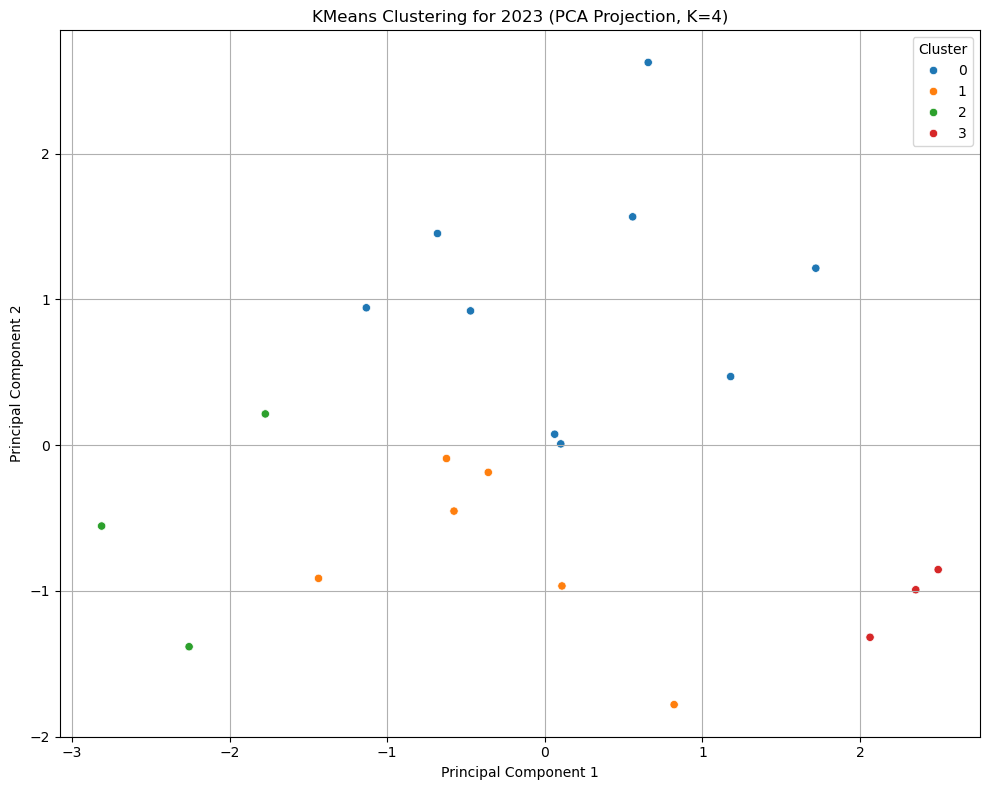


Cluster Summary for 2023 (sorted by median score):


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
median_gap_days,11.000000,2.000000,2.000000,4.750000
active_days_count,3.000000,13.000000,8.000000,4.000000
activities_count,12.000000,88.000000,23.000000,28.500000
activity_types_count,2.000000,2.000000,2.000000,3.000000
median_activity_duration_minutes,1.283333,2.400000,5.158333,1.479167
median_score,77.647059,65.882353,62.500000,45.832500
users_count,3.000000,3.000000,9.000000,6.000000


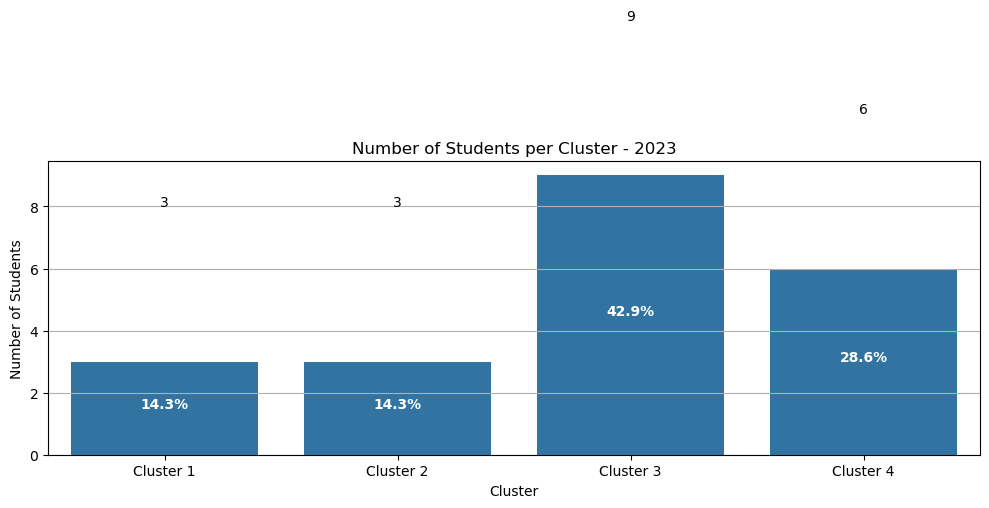


--- Clustering Students for 2024 ---
Students after removing NaN: 371 (removed 24 rows)


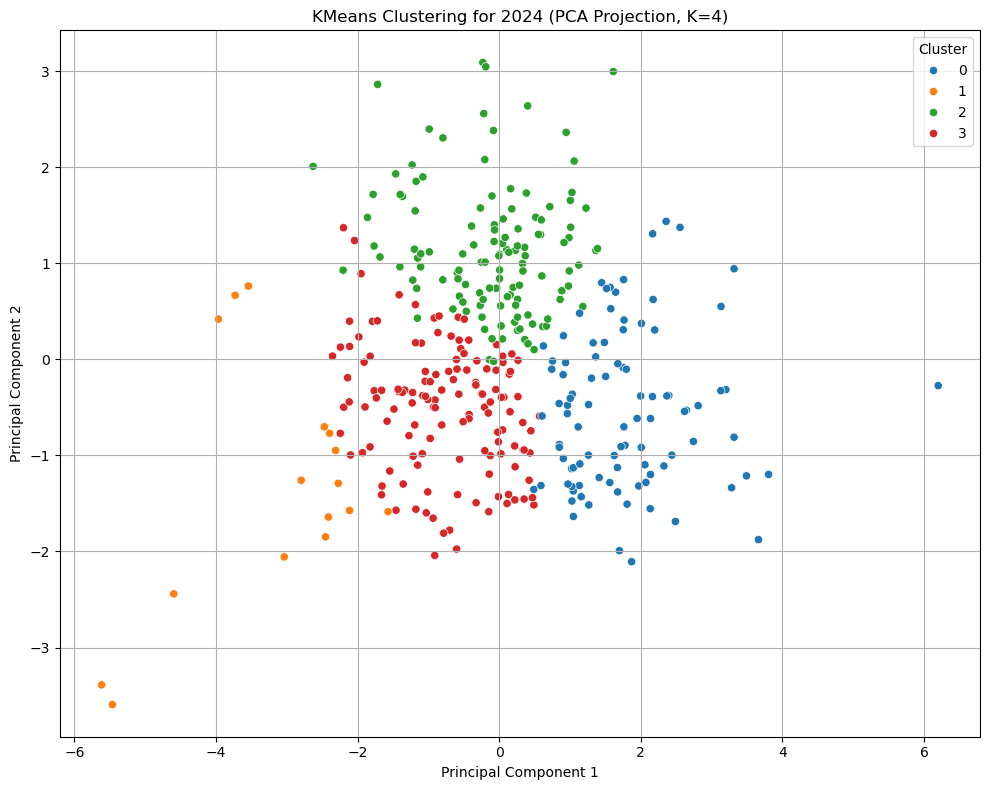


Cluster Summary for 2024 (sorted by median score):


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
median_gap_days,37.5000,7.000000,5.500000,4.000000
active_days_count,2.5000,5.000000,12.000000,14.000000
activities_count,5.0000,15.000000,27.000000,60.000000
activity_types_count,2.0000,2.000000,2.000000,3.000000
median_activity_duration_minutes,4.9125,4.350000,11.483333,3.054167
median_score,74.0000,65.882353,64.585000,57.320000
users_count,16.0000,136.000000,125.000000,94.000000


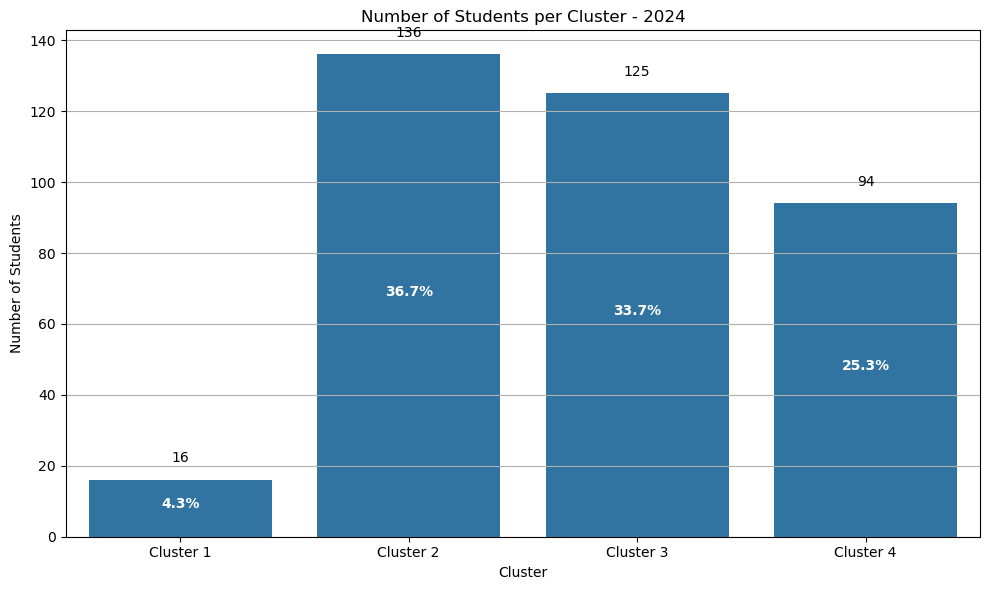


--- Clustering Students for 2025 ---
Students after removing NaN: 159 (removed 16 rows)


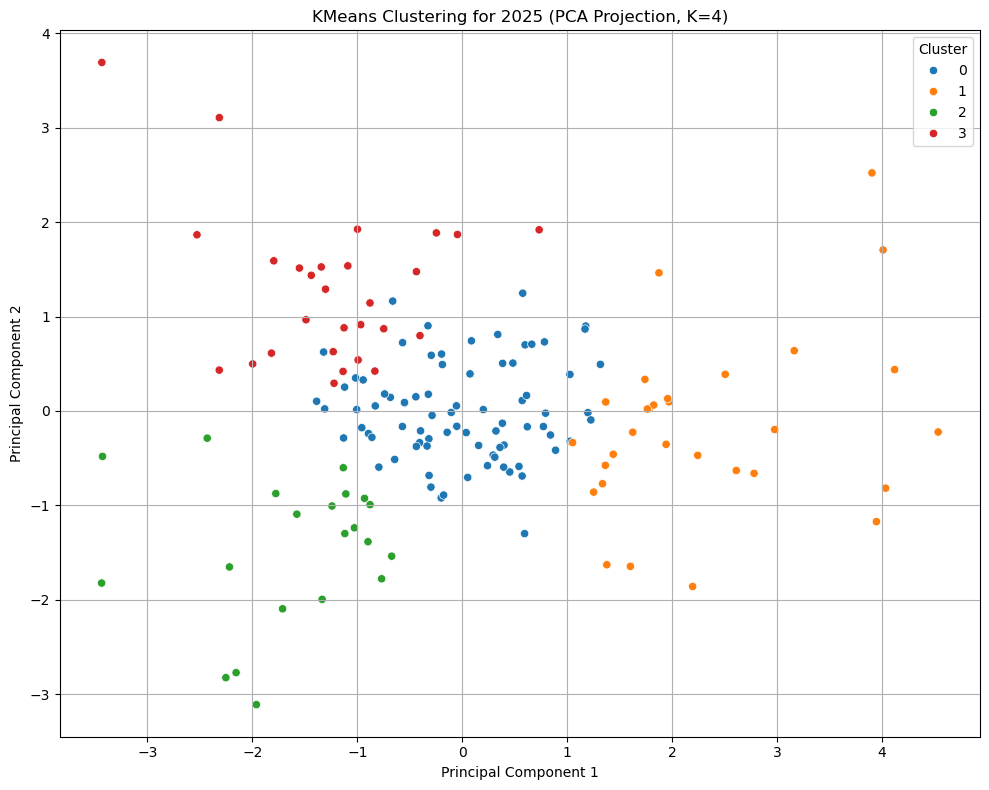


Cluster Summary for 2025 (sorted by median score):


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
median_gap_days,25.000000,6.750000,5.2500,3.000000
active_days_count,2.000000,3.000000,4.0000,7.000000
activities_count,6.000000,5.500000,12.5000,39.500000
activity_types_count,2.000000,2.000000,2.0000,3.000000
median_activity_duration_minutes,3.691667,19.516667,5.4875,2.658333
median_score,70.835000,57.640000,54.2850,53.660000
users_count,21.000000,28.000000,80.0000,30.000000


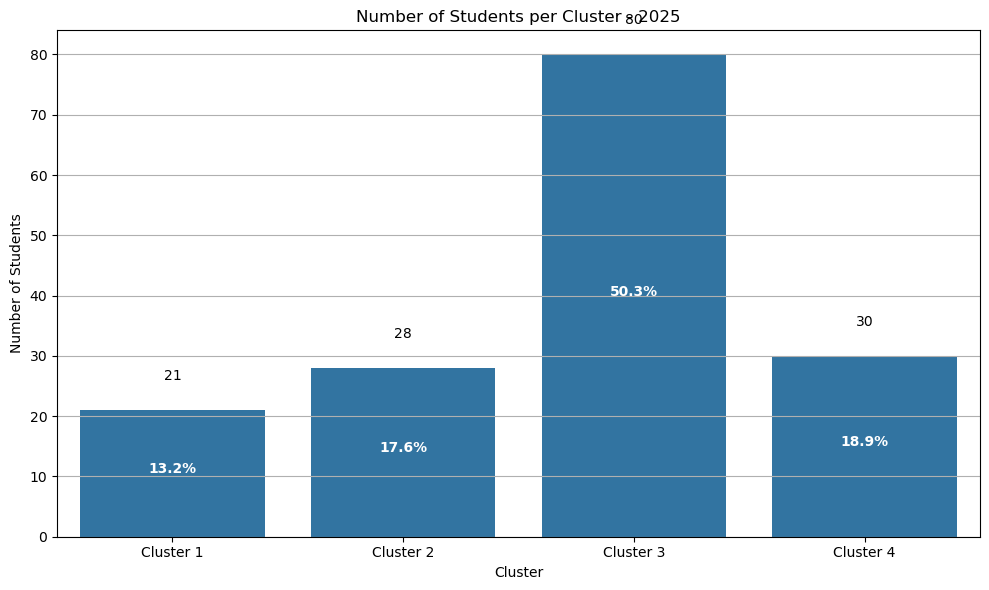


--- Comparing Cluster Characteristics Across Periods ---

Comparison of Cluster 1 across periods:


,2023,2024,2025
median_gap_days,11.000000,37.5000,25.000000
active_days_count,3.000000,2.5000,2.000000
activities_count,12.000000,5.0000,6.000000
activity_types_count,2.000000,2.0000,2.000000
median_activity_duration_minutes,1.283333,4.9125,3.691667
median_score,77.647059,74.0000,70.835000
users_count,3.000000,16.0000,21.000000



Comparison of Cluster 2 across periods:


,2023,2024,2025
median_gap_days,2.000000,7.000000,6.750000
active_days_count,13.000000,5.000000,3.000000
activities_count,88.000000,15.000000,5.500000
activity_types_count,2.000000,2.000000,2.000000
median_activity_duration_minutes,2.400000,4.350000,19.516667
median_score,65.882353,65.882353,57.640000
users_count,3.000000,136.000000,28.000000



Comparison of Cluster 3 across periods:


,2023,2024,2025
median_gap_days,2.000000,5.500000,5.2500
active_days_count,8.000000,12.000000,4.0000
activities_count,23.000000,27.000000,12.5000
activity_types_count,2.000000,2.000000,2.0000
median_activity_duration_minutes,5.158333,11.483333,5.4875
median_score,62.500000,64.585000,54.2850
users_count,9.000000,125.000000,80.0000



Comparison of Cluster 4 across periods:


,2023,2024,2025
median_gap_days,4.750000,4.000000,3.000000
active_days_count,4.000000,14.000000,7.000000
activities_count,28.500000,60.000000,39.500000
activity_types_count,3.000000,3.000000,3.000000
median_activity_duration_minutes,1.479167,3.054167,2.658333
median_score,45.832500,57.320000,53.660000
users_count,6.000000,94.000000,30.000000



--- Analyzing User Transitions Between Clusters Across Periods ---

Transitions from 2023 to 2024 (4 users)


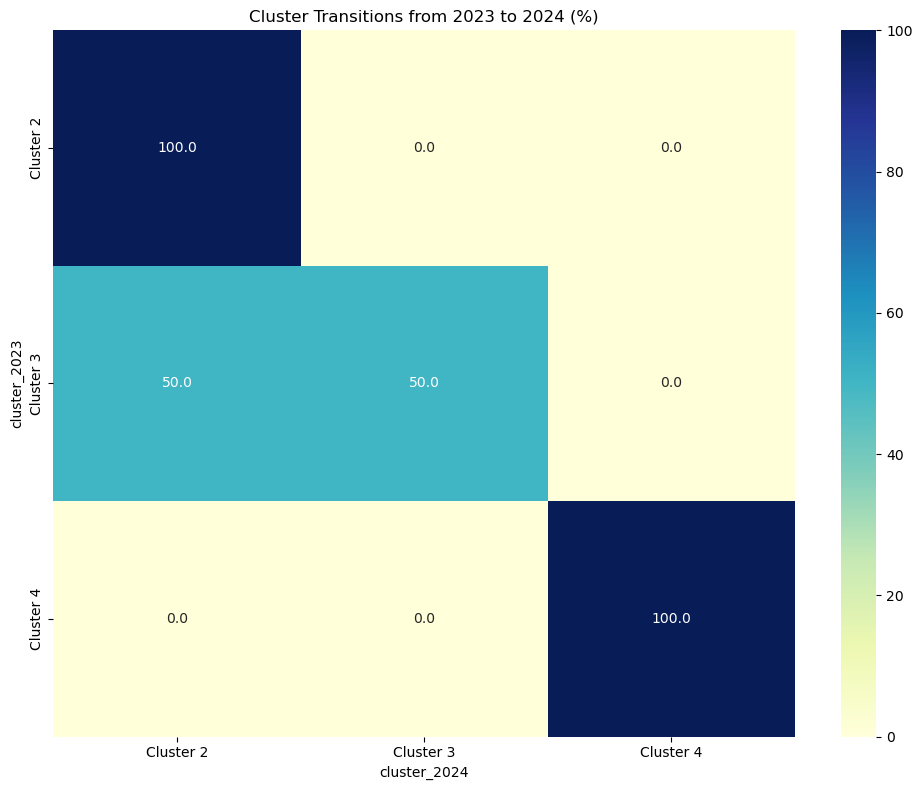

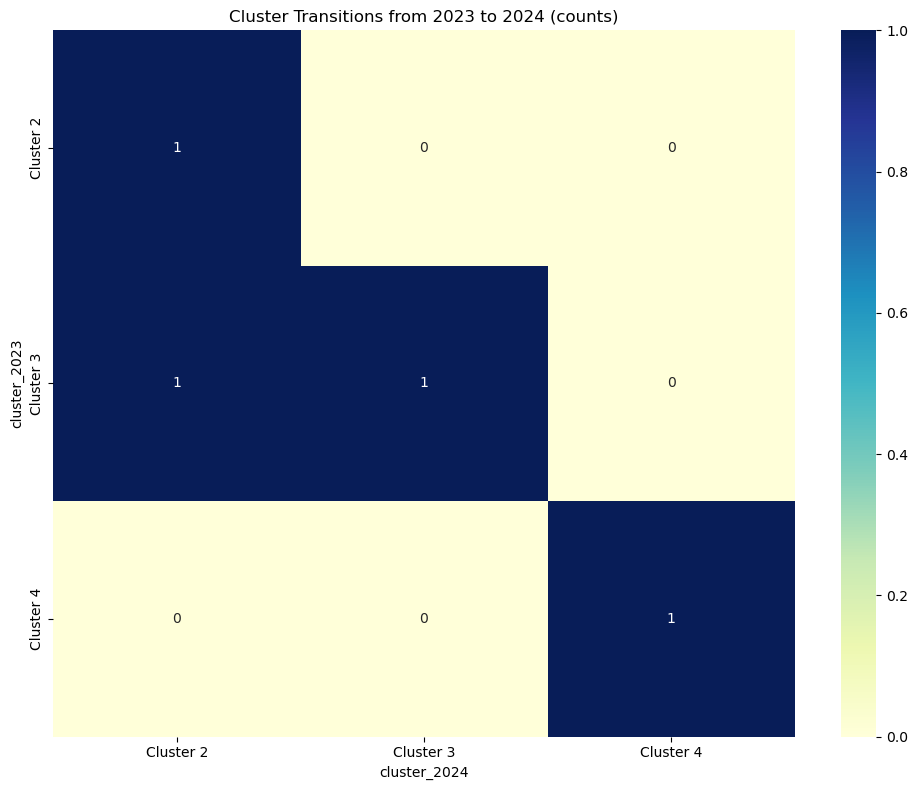


Transitions from 2024 to 2025 (120 users)


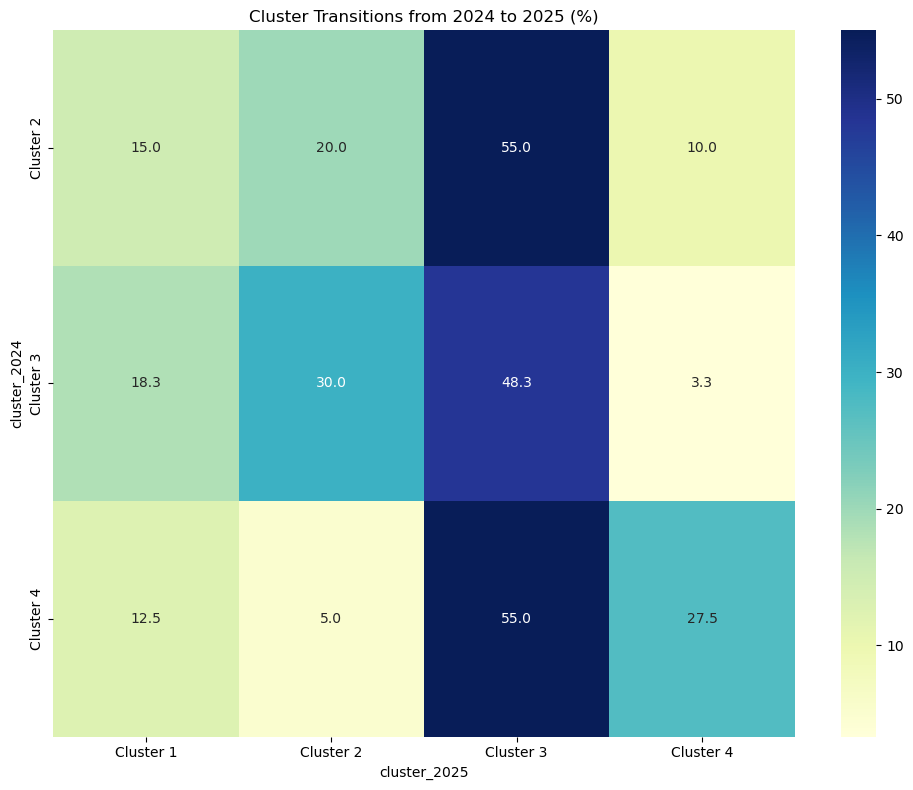

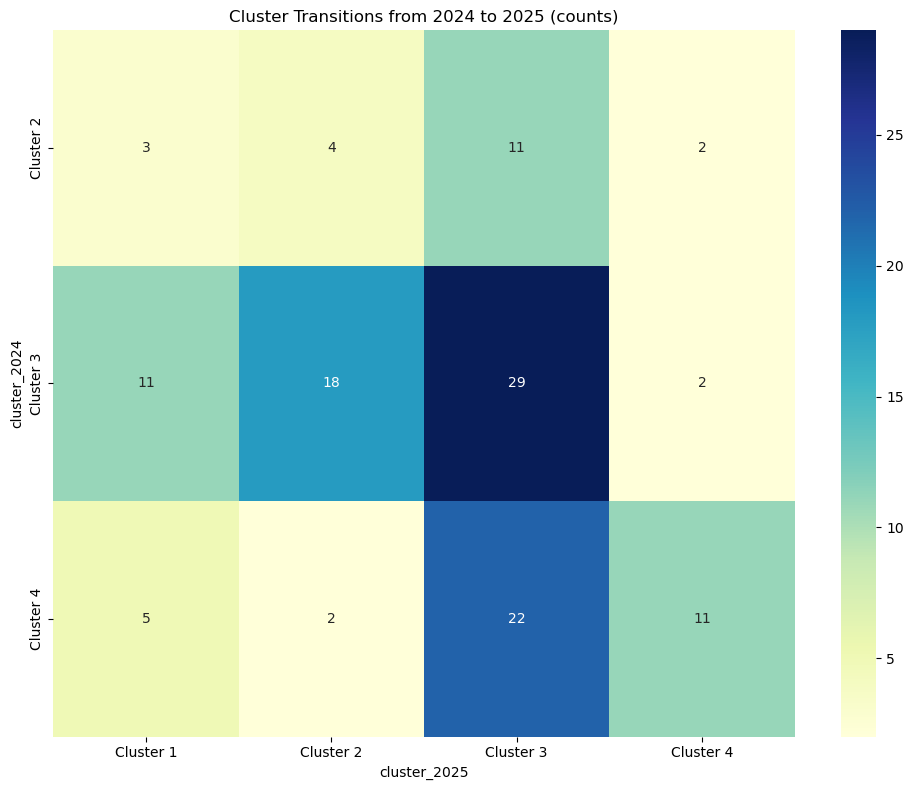

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def cluster_students_by_period(students_by_period, k=4):
    """
    Applies KMeans clustering to students from each period separately.
    
    Parameters:
    -----------
    students_by_period : dict
        Dictionary of student dataframes for each period
    k : int, default=4
        Number of clusters to use
    
    Returns:
    --------
    dict
        Dictionary of clustered student dataframes for each period
    """
    # Features used for clustering
    columns_used = [
        'median_gap_days',
        'active_days_count',
        'activities_count',
        'activity_types_count',
        'median_activity_duration_minutes'
    ]
    
    clustered_students = {}
    cluster_summaries = {}
    
    for period_name, df in students_by_period.items():
        print(f"\n--- Clustering Students for {period_name} ---")
        
        if df is None or len(df) == 0:
            print(f"No data for {period_name}, skipping...")
            continue
            
        # Clean the data - remove rows with NaN in any of the columns used for clustering
        students_no_nan = df.dropna(subset=columns_used)
        print(f"Students after removing NaN: {len(students_no_nan)} (removed {len(df) - len(students_no_nan)} rows)")
        
        if len(students_no_nan) < k:
            print(f"Not enough data points for {period_name} to perform clustering with k={k}, skipping...")
            continue
        
        # Extract features for clustering
        X = students_no_nan[columns_used]
        
        # Normalize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply KMeans with specified K
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        students_no_nan = students_no_nan.copy()
        students_no_nan['cluster'] = kmeans.fit_predict(X_scaled)
        
        # Create visualizations
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Apply PCA to reduce to 2D for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # Add PCA components to the DataFrame
        students_projection_pca = students_no_nan.copy()
        students_projection_pca['PCA1'] = X_pca[:, 0]
        students_projection_pca['PCA2'] = X_pca[:, 1]
        
        # Plot Cluster scatterplot using PCA components
        sns.scatterplot(
            data=students_projection_pca,
            x='PCA1',
            y='PCA2',
            hue='cluster',
            palette='tab10',
            ax=ax
        )
        ax.set_title(f"KMeans Clustering for {period_name} (PCA Projection, K={k})")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.legend(title='Cluster')
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Median feature values per cluster
        cluster_values = students_no_nan.groupby('cluster')[columns_used].median().T
        
        # Compute median score and user count per cluster
        cluster_score_raw = students_no_nan.groupby('cluster').agg(
            median_score=('median_score', 'median'),
            users_count=('user_id', 'nunique')
        )
        
        # Sort clusters by decreasing median_score
        sorted_clusters = cluster_score_raw.sort_values(by='median_score', ascending=False).index.tolist()
        cluster_values = cluster_values[sorted_clusters]
        cluster_score = cluster_score_raw.loc[sorted_clusters].T
        
        # Rename columns to "Cluster 1", "Cluster 2", etc.
        new_columns = [f'Cluster {i+1}' for i in range(len(sorted_clusters))]
        cluster_values.columns = new_columns
        cluster_score.columns = new_columns
        
        # Combine values + scores
        cluster_values_df = pd.concat([cluster_values, cluster_score], axis=0)
        
        print(f"\nCluster Summary for {period_name} (sorted by median score):")
        display(cluster_values_df)
        
        # Update cluster labels in the dataframe based on sorted order
        cluster_mapping = {old_cluster: i for i, old_cluster in enumerate(sorted_clusters)}
        students_no_nan['sorted_cluster'] = students_no_nan['cluster'].map(cluster_mapping)
        students_no_nan['cluster_name'] = 'Cluster ' + (students_no_nan['sorted_cluster'] + 1).astype(str)
        
        # Store results
        clustered_students[period_name] = students_no_nan
        cluster_summaries[period_name] = cluster_values_df
        
        # Show distribution of students across clusters
        plt.figure(figsize=(10, 6))
        cluster_counts = students_no_nan['cluster_name'].value_counts().sort_index()
        ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
        plt.title(f"Number of Students per Cluster - {period_name}")
        plt.xlabel("Cluster")
        plt.ylabel("Number of Students")
        plt.grid(axis='y')
        
        # Add count labels on top of bars
        for i, count in enumerate(cluster_counts.values):
            ax.text(i, count + 5, str(count), ha='center')
            
        # Add percentage labels inside bars
        total = cluster_counts.sum()
        for i, count in enumerate(cluster_counts.values):
            percentage = count / total * 100
            ax.text(i, count/2, f"{percentage:.1f}%", ha='center', color='white', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
    # Compare cluster characteristics across periods
    if len(cluster_summaries) > 1:
        print("\n--- Comparing Cluster Characteristics Across Periods ---")
        
        # For each cluster number, compare its characteristics across periods
        max_clusters = max(len(summary.columns) for summary in cluster_summaries.values())
        
        for cluster_num in range(1, max_clusters + 1):
            cluster_name = f'Cluster {cluster_num}'
            
            # Check which periods have this cluster
            periods_with_cluster = [period for period, summary in cluster_summaries.items() 
                                    if cluster_name in summary.columns]
            
            if len(periods_with_cluster) > 1:
                # Create comparison dataframe
                comparison_data = {}
                for period in periods_with_cluster:
                    comparison_data[period] = cluster_summaries[period][cluster_name]
                
                comparison_df = pd.DataFrame(comparison_data)
                
                print(f"\nComparison of {cluster_name} across periods:")
                display(comparison_df)
    
    return clustered_students, cluster_summaries

# Apply clustering to each period with k=4
clustered_students_by_period, cluster_summaries_by_period = cluster_students_by_period(students_by_period, k=4)

# Optional: Analyze how users transition between clusters across periods
if len(clustered_students_by_period) > 1:
    print("\n--- Analyzing User Transitions Between Clusters Across Periods ---")
    
    # Get all periods in chronological order
    periods = sorted(clustered_students_by_period.keys())
    
    for i in range(len(periods) - 1):
        current_period = periods[i]
        next_period = periods[i+1]
        
        # Get users present in both periods
        current_df = clustered_students_by_period[current_period]
        next_df = clustered_students_by_period[next_period]
        
        common_users = set(current_df['user_id']) & set(next_df['user_id'])
        
        if len(common_users) > 0:
            print(f"\nTransitions from {current_period} to {next_period} ({len(common_users)} users)")
            
            # Create transition dataframe
            current_clusters = current_df[current_df['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
            next_clusters = next_df[next_df['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
            
            transitions = pd.DataFrame({
                'cluster_' + current_period: current_clusters,
                'cluster_' + next_period: next_clusters
            })
            
            # Create transition matrix
            transition_counts = transitions.groupby(['cluster_' + current_period, 'cluster_' + next_period]).size().unstack(fill_value=0)
            
            # Convert to percentages (rows sum to 100%)
            transition_percentages = transition_counts.div(transition_counts.sum(axis=1), axis=0) * 100
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(transition_percentages, annot=True, cmap='YlGnBu', fmt='.1f')
            plt.title(f"Cluster Transitions from {current_period} to {next_period} (%)")
            plt.tight_layout()
            plt.show()
            
            # Also show raw counts
            plt.figure(figsize=(10, 8))
            sns.heatmap(transition_counts, annot=True, cmap='YlGnBu', fmt='d')
            plt.title(f"Cluster Transitions from {current_period} to {next_period} (counts)")
            plt.tight_layout()
            plt.show()

In [80]:
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as mcolors

label_list = []
label_index = {}
label_counter = 0
source = []
target = []
value = []
link_colors = []

# Store positions and period groups
x_positions = {}
label_to_period = {}
period_to_labels = {}

# Step 1: Assign x positions and gather clusters per period
periods = sorted(clustered_students_by_period.keys())
n_periods = len(periods)

for i, period_name in enumerate(periods):
    df = clustered_students_by_period.get(period_name)
    if df is not None and len(df) > 0:
        clusters = sorted(df['cluster_name'].unique())
        period_to_labels[period_name] = []
        x = i / (n_periods - 1) if n_periods > 1 else 0.5
        for cluster in clusters:
            short_label = cluster
            unique_label = short_label + f"__{period_name}"
            label_to_period[unique_label] = period_name
            period_to_labels[period_name].append(unique_label)
            label_index[unique_label] = label_counter
            label_list.append(short_label)
            x_positions[label_counter] = x
            label_counter += 1

# Get a colormap (e.g., tab20)
colormap = cm.get_cmap('tab20', 20)

# Step 2: Create transition links with color
transition_id = 0
for i in range(len(periods) - 1):
    p1 = periods[i]
    p2 = periods[i + 1]
    
    df1 = clustered_students_by_period[p1]
    df2 = clustered_students_by_period[p2]
    
    common_users = set(df1['user_id']) & set(df2['user_id'])
    if len(common_users) == 0:
        continue
    
    df1_clusters = df1[df1['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
    df2_clusters = df2[df2['user_id'].isin(common_users)].set_index('user_id')['cluster_name']
    
    transitions_df = pd.DataFrame({
        'from': df1_clusters,
        'to': df2_clusters
    })
    
    grouped = transitions_df.groupby(['from', 'to']).size().reset_index(name='count')
    
    for _, row in grouped.iterrows():
        src_label = row['from'] + f"__{p1}"
        tgt_label = row['to'] + f"__{p2}"
        cnt = row['count']
        
        source.append(label_index[src_label])
        target.append(label_index[tgt_label])
        value.append(cnt)

        # Pick a color from the colormap
        rgba = colormap(transition_id % 20)
        hex_color = mcolors.to_hex(rgba)
        link_colors.append(hex_color)
        transition_id += 1

# Step 3: Set node x-positions based on period
x_vals = [x_positions[i] for i in range(len(label_list))]
y_vals = None  # Let Plotly auto-arrange vertically

# Step 4: Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        x=x_vals,
        y=y_vals,
        color="lightblue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

# Step 5: Add period annotations
annotations = []
for i, period in enumerate(periods):
    x = i / (n_periods - 1) if n_periods > 1 else 0.5
    annotations.append(dict(
        x=x,
        y=1.1,
        text=period,
        showarrow=False,
        xanchor='center',
        font=dict(size=16, color='black')
    ))

fig.update_layout(
    title_text="User Cluster Transitions Across Periods",
    font_size=12,
    annotations=annotations,
    margin=dict(t=80)
)

fig.show()


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_5363/3281130480.py:39: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

